# nmoo quick example

Also available on Google Colab [![Launch Google Colab
notebook](https://img.shields.io/badge/launch-colab-blue?logo=googlecolab)](https://colab.research.google.com/github/altaris/noisy-moo/blob/main/example.ipynb)

In this notebook, we consider a ZDT1 problem with Gaussian noise, and benckmark two "denoising" methods:
* a naive average method,
* the KNN-Avg algorithm.

# Specifying the benchmark

In [1]:
import nmoo

The first step is to construct our problem pipelines. We start with a `ZDT1`
instance, that we wrap in a `WrappedProblem`. In nmoo, `WrappedProblem` is the
base class to modify problems, in our case adding and removing noise.
Additionally, `WrappedProblem` and classes deriving from it maintain a history
of every call made to their `_evaluate` method (see the [pymoo
documentation](https://pymoo.org/getting_started.html#By-Class)).

Next, we add a Gaussian noise of type `N(0, 0.25)` and the averaging algorithm.

While it is possible to feed `zdt1` directly into a `GaussianNoise`, the point
of using an intermediate `wrapped_zdt1` is to keep a history of all calls to
the non-noisy ZDT1.

In [2]:
from pymoo.config import Config
Config.show_compile_hint = False

from pymoo.problems.multi import ZDT1
import numpy as np

zdt1 = ZDT1()
wrapped_zdt1 = nmoo.WrappedProblem(zdt1)

mean = np.array([0, 0])
covariance = np.array([[1., -.5], [-.5, 1]])
noisy_zdt1 = nmoo.GaussianNoise(wrapped_zdt1, mean, covariance)

avg_zdt1 = nmoo.ResampleAverage(noisy_zdt1, n_evaluations=10)

We construct a similar pipeline for the KNN-Avg algorithm (`max_distance` is
just a parameter of the algorithm). Note that parts of an already existing
pipeline can be reused. Behind the scene, `noisy_zdt1` will be deepcopied.

In [3]:
knnavg_zdt1 = nmoo.KNNAvg(noisy_zdt1, max_distance=1.)

Now, we setup an algorithm that will try and solve our `avg_zdt1` and `knnavg_zdt1` problems.

In [4]:
from pymoo.algorithms.moo.nsga2 import NSGA2

nsga2 = NSGA2()

Finally, we setup our benchmark. It will run NSGA2 against `avg_zdt1` and
`knnavg_zdt1` tree times each. Additionally, we specify a Pareto front
population to measure the performance. It no Pareto front is specified (or
known), performance indicators will use one automatically calculated based on
the results of the benchmark.

Since the `avg` problem evaluates the underlying noisy `ZDT1` problem 10 times,
we apply a penalty of 10, meaning that every call to `avg.eval` will count as
10 calls.

For more information on how to specify the problems and the algorithms, refer
to [the documentation](https://altaris.github.io/noisy-moo/nmoo/benchmark.html#Benchmark.__init__).

In [5]:
from pymoo.factory import get_termination

pareto_front = zdt1.pareto_front(100)

benchmark = nmoo.Benchmark(
    output_dir_path="./out",
    problems={
        "knnavg": {
            "problem": knnavg_zdt1,
            "pareto_front": pareto_front,
        },
        "avg": {
            "problem": avg_zdt1,
            "pareto_front": pareto_front,
            "evaluator": nmoo.PenalizedEvaluator(10),
        },
    },
    algorithms={
        "nsga2": {
            "algorithm": nsga2,
        },
        "nsga2_100": {
            "algorithm": nsga2,
            "termination": get_termination("n_gen", 100),
        },
    },
    n_runs=3,
)

# Running the benchmark

In [6]:
benchmark.run(verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.show_compile_hint = False


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.show_compile_hint = False


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.show_compile_hint = False


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.show_compile_hint = False


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.show_compile_hint = False



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   17.3s remaining:   52.0s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   28.5s remaining:   39.9s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   32.1s remaining:   22.9s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   32.8s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done   4 tasks     

# Benchmark results

Results of the benchmark are automatically saved. Refer to
[the documentation](https://altaris.github.io/noisy-moo/nmoo/benchmark.html) for a precise
explanation of the role of each artefact.

In [7]:
! ls ./out | head

avg.nsga2.1.1-resample_avg.npz
avg.nsga2.1.2-gaussian_noise.npz
avg.nsga2.1.3-wrapped_problem.npz
avg.nsga2.1.csv
avg.nsga2.1.pi-igd.csv
avg.nsga2.1.pp.npz
avg.nsga2.2.1-resample_avg.npz
avg.nsga2.2.2-gaussian_noise.npz
avg.nsga2.2.3-wrapped_problem.npz
avg.nsga2.2.csv


Let's now visualize the results. The final result of all runs can be found using the `Benchmark.final_results` method:

In [8]:
benchmark.final_results()

,algorithm,problem,n_run,n_gen,n_eval,timedelta,perf_igd
0,nsga2,avg,1,100,100000,29841,0.201766
1,nsga2,avg,2,100,100000,129711,0.119726
2,nsga2,avg,3,100,100000,144749,0.131315
3,nsga2,knnavg,1,165,16500,698527,0.190680
4,nsga2,knnavg,2,225,22500,108498,0.150406
5,nsga2,knnavg,3,262,26200,803547,0.173940
6,nsga2_100,avg,1,100,100000,102262,0.315564
7,nsga2_100,avg,2,100,100000,849192,0.259745
8,nsga2_100,avg,3,100,100000,817981,0.337144
9,nsga2_100,knnavg,1,100,10000,429142,0.274805


# Plotting

The following plot depicts the IGD performance of averaging vs. KNN-averaging.

<AxesSubplot:xlabel='problem', ylabel='perf_igd'>

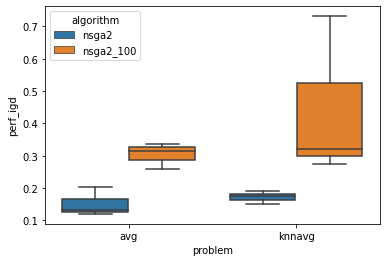

In [9]:
import seaborn as sns

sns.boxplot(
    x="problem", 
    y="perf_igd", 
    hue="algorithm",
    data=benchmark.final_results(),
)

The following boxplot depicts the runtimes.

<AxesSubplot:xlabel='problem', ylabel='timedelta'>

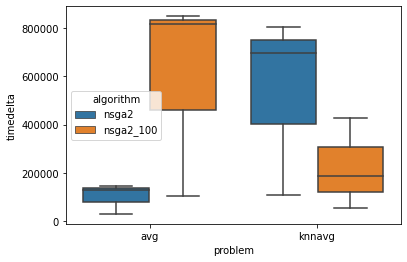

In [10]:
sns.boxplot(
    x="problem", 
    y="timedelta", 
    hue="algorithm",
    data=benchmark.final_results(),
)

`nmoo` also offers a few plotting primitives, see [the documentation](https://altaris.github.io/noisy-moo/nmoo/plotting.html).

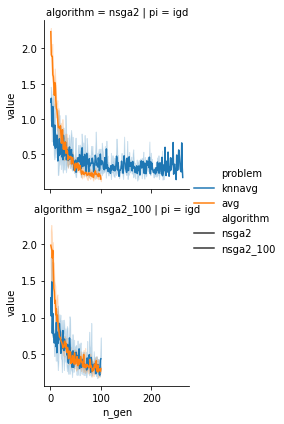

In [11]:
nmoo.plot_performance_indicators(benchmark, row="algorithm")